<a href="https://colab.research.google.com/github/Alepescinaa/ScientificTools/blob/main/Project2/Cp2/Checkpoint2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal well disposition for the Darcy problem

## Import

In [1]:
%%capture
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project2/Cp2

!apt-get update
!apt-get install libglu1-mesa

!git clone https://github.com/pmgbergen/porepy.git
%cd porepy

!git checkout main

!pip install -r requirements.txt

!pip install .

%cd ..

In [2]:
import sys
import scipy
import numpy as np
import porepy as pp
from tqdm import tqdm
import multiprocessing
import scipy.sparse as sps
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [3]:
main_folder = "./"
spe10_folder = main_folder + "spe10"
sys.path.insert(1, spe10_folder)

from functions import *
from spe10 import Spe10

## Fine solver

In [4]:
def solve_fine(spe10, pos_well, injection_rate=1, well_pressure=0, export_folder=None):
    """
    Compute the averaged gradient and flux for a given subdomain and direction of the pressure
    gradient.

    Args:
        spe10 (object): The object representing the subdomain.
        pos_well (np.ndarray): The position of the production well.
        injection_rate (float, optional): The injection rate of the wells. Defaults to 1.
        well_pressure (float, optional): The pressure at the production well. Defaults to 0.
        export_folder (str, optional): If given, path where to export the results. Defaults to
            None.

    Returns:
        float: The maximum pressure at the injection wells.
    """
    # Extract the grid for simplicity
    sd = spe10.sd
    perm_dict = spe10.perm_as_dict()

    # Permeability
    perm_tensor = pp.SecondOrderTensor(kxx=perm_dict["kxx"])
    #print(perm_tensor)

    # Boundary conditions
    b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]

    # Define the labels and values for the boundary faces
    labels = np.array(["neu"] * b_faces.size)
    bc_val = np.zeros(sd.num_faces)
    bc = pp.BoundaryCondition(sd, b_faces, labels)

    # Collect all parameters in a dictionary
    key = "flow"
    parameters = {"second_order_tensor": perm_tensor, "bc": bc, "bc_values": bc_val}
    data = pp.initialize_default_data(sd, {}, key, parameters)

    # Discretize the problem
    discr = pp.Mpfa(key)
    discr.discretize(sd, data)

    A, b = discr.assemble_matrix_rhs(sd, data)

    # Add the injection wells, all with the same injection rate
    b_wells = np.zeros_like(b)
    index_iwells = [
        0,
        spe10.full_shape[0] - 1,
        spe10.full_shape[0] * spe10.full_shape[1] - spe10.full_shape[0],
        spe10.full_shape[0] * spe10.full_shape[1] - 1,
    ]
    b_wells[index_iwells] = injection_rate

    # Add the production well by using a Lagrange multiplier, first we identify the cell
    ij_well = np.floor((np.asarray(pos_well) / spe10.spacing[:-1])).astype(int)
    #print(ij_well)
    index_pwell = spe10.full_shape[0] * ij_well[1] + ij_well[0]
    vect = np.zeros((sd.num_cells, 1))
    vect[index_pwell] = 1

    # Solve the linear system and compute the pressure by adding the constraint
    A = sps.bmat([[A, vect], [vect.T, None]], format="csc")
    b = np.append(b + b_wells, well_pressure)
    p = sps.linalg.spsolve(A, b)[:-1]

    # extract the discretization matrices build
    mat_discr = data[pp.DISCRETIZATION_MATRICES][key]

    # reconstruct the flux as post-process
    q_tpfa = mat_discr["flux"] @ p + mat_discr["bound_flux"] @ bc_val

    # to export the flux
    mvem = pp.MVEM(key)
    mvem.discretize(sd, data)
    # construct the P0 flux reconstruction
    cell_q_mpfa = mvem.project_flux(sd, q_tpfa, data)


    # Export the solution
    if export_folder is not None:
        save = pp.Exporter(sd, "sol", folder_name=export_folder)
        save.write_vtu([("p", p), ("log_kxx", np.log10(perm_dict["kxx"])),("q_mpfa", cell_q_mpfa)])

    # Return the maximum pressure at the injection wells
    return np.max(p[index_iwells])

## Upscaling

In [5]:
def upscale(sd, perm, dir, export_folder=None):
    """
    Compute the averaged gradient and flux for a given subdomain and direction of the pressure
    gradient.

    Args:
        sd (pp.Grid): The grid representing the subdomain.
        perm (dict): The permeability of the subdomain divided in the fields "kxx" and "kyy"
        dir (int): The direction of the flow, 0 means x-direction and 1 means y-direction.
        export_folder (str): If given, path where to export the results.
            Default to None, no exporting.

    Returns:
        (np.ndarray, np.ndarray): averaged gradient and flux.
    """
    # Permeability
    perm_tensor = pp.SecondOrderTensor(kxx=perm["kxx"], kyy=perm["kyy"])

    # Boundary conditions
    b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]
    b_face_centers = sd.face_centers[:, b_faces]

    # Find the min and max values of the boundary faces
    sd_min = np.amin(sd.face_centers[dir, :])
    sd_max = np.amax(sd.face_centers[dir, :])

    # define outflow and inflow type boundary conditions
    out_flow = np.isclose(b_face_centers[dir, :], sd_max)
    in_flow = np.isclose(b_face_centers[dir, :], sd_min)

    # define the labels and values for the boundary faces
    labels = np.array(["neu"] * b_faces.size)
    labels[np.logical_or(in_flow, out_flow)] = "dir"

    bc_val = np.zeros(sd.num_faces)
    bc_val[b_faces[in_flow]] = sd_max - sd_min

    bc = pp.BoundaryCondition(sd, b_faces, labels)

    # Collect all parameters in a dictionary
    key = "flow"
    parameters = {"second_order_tensor": perm_tensor, "bc": bc, "bc_values": bc_val}
    data = pp.initialize_default_data(sd, {}, key, parameters)

    # Discretize the problem (construct the lhr and rhs)
    discr = pp.Tpfa(key)
    discr.discretize(sd, data)

    A, b = discr.assemble_matrix_rhs(sd, data)

    # Solve the linear system and compute the pressure
    p = sps.linalg.spsolve(A, b)

    # Export the solution
    if export_folder is not None:
        save = pp.Exporter(sd, "sol", folder_name=export_folder)
        save.write_vtu([("p", p), ("log_perm", np.log10(perm["kxx"]))])

    # Post-process the solution to get the flux
    return compute_avg_q_grad(sd, p, data, key, bc, bc_val)

In [6]:
def compute_tensor(grad_h, grad_v, q_h, q_v):
    """
    Compute the upscaled permeability tensor.

    Args:
        grad_h (np.ndarray): Gradient in the horizontal direction.
        grad_v (np.ndarray): Gradient in the vertical direction.
        q_h (np.ndarray): Flux in the horizontal direction.
        q_v (np.ndarray): Flux in the vertical direction.

    Returns:
        perm (np.ndarray): Upscaled permeability tensor.

    The function solves a linear system to obtain the upscaled permeability tensor
    based on the given gradients and fluxes. It enforces numerical symmetry and
    checks if the resulting tensor is symmetric positive definite (SPD).
    """
    # Solve the linear system to get the upscaled permeability
    lhs = np.array([
        [grad_h[0], grad_h[1], 0, 0],
        [0, 0, grad_h[0], grad_h[1]],
        [grad_v[0], grad_v[1], 0, 0],
        [0, 0, grad_v[0], grad_v[1]],
        [0, 1, -1, 0]
    ])

    rhs = np.array([q_h[0], q_h[1], q_v[0], q_v[1], 0])

    perm = np.linalg.lstsq(lhs, rhs, rcond=None)[0]

    # make it symmetric positive definite
    perm = nearest_spd(perm.reshape(2, 2)).ravel()

    return perm

In [7]:
def process_subdomain(sub_sd_id, sub_sd, perm_dict, folder_results, part, kxx_up, kxy_up, kyx_up, kyy_up):
    mask = part == sub_sd_id
    sub_perm = {key: val[mask] for key, val in perm_dict.items()}

    folder_x = folder_results + str(sub_sd_id) + "_x"
    q_h, grad_h = upscale(sub_sd, sub_perm, 0, folder_x)

    folder_y = folder_results + str(sub_sd_id) + "_y"
    q_v, grad_v = upscale(sub_sd, sub_perm, 1, folder_y)

    kk = compute_tensor(grad_h, grad_v, q_h, q_v)

    return [kk[0], kk[1], kk[2], kk[3]]

def Checkpoint1_solution(selected_layers, folder_results):
    spe10 = Spe10(selected_layers)
    perm_folder = spe10_folder + "/perm/"
    spe10.read_perm(perm_folder)
    perm_dict = spe10.perm_as_dict()

    num_part = 100
    part, sub_sds, sd_coarse = coarse_grid(spe10.sd, num_part)

    kxx_up = np.zeros(spe10.sd.num_cells)
    kxy_up = np.zeros(spe10.sd.num_cells)
    kyx_up = np.zeros(spe10.sd.num_cells)
    kyy_up = np.zeros(spe10.sd.num_cells)
    kxx = np.zeros(spe10.sd.num_cells)

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    result = pool.starmap_async(process_subdomain, [(sub_sd_id, sub_sd, perm_dict, folder_results, part, kxx_up, kxy_up, kyx_up, kyy_up) for sub_sd_id, sub_sd in enumerate(sub_sds)]).get()

    for sub_sd_id, kk in enumerate(result):
        mask = part == sub_sd_id
        sub_perm = {key: val[mask] for key, val in perm_dict.items()}
        kxx[mask] = sub_perm["kxx"]
        kxx_up[mask], kxy_up[mask], kyx_up[mask], kyy_up[mask] = kk
        #print(f"Subdomain {sub_sd_id}: {kk}")

    var_to_save = [
        ("kxx", np.log10(kxx_up)),
        ("kxy", kxy_up),
        ("kyx", kyx_up),
        ("kyy", np.log10(kyy_up)),
        ("fine", np.log10(kxx))
    ]

    save = pp.Exporter(spe10.sd, "upscaled_k", folder_name=folder_results)
    save.write_vtu(var_to_save)

    write_upscaled_perm("as_tensor", sd_coarse, result, folder_results)

    return sd_coarse, result

## Solve coarse

In [8]:
def solve_coarse(
    sd,
    pos_well,
    kk,
    injection_rate=1,
    well_pressure=0,
    export_folder=None,
):
    """
    Compute the averaged gradient and flux for a given subdomain and direction of the pressure
    gradient.

    Args:
        spe10 (object): The object representing the subdomain.
        pos_well (np.ndarray): The position of the production well.
        injection_rate (float, optional): The injection rate of the wells. Defaults to 1.
        well_pressure (float, optional): The pressure at the production well. Defaults to 0.
        export_folder (str, optional): If given, path where to export the results. Defaults to
            None.

    Returns:
        float: The maximum pressure at the injection wells.
    """

    # Permeability
    result = np.array(kk).T
    perm_tensor = pp.SecondOrderTensor(kxx=result[0], kyy=result[3], kxy=result[1])
    #print(perm_tensor)

    # Boundary conditions
    b_faces = sd.tags["domain_boundary_faces"].nonzero()[0]

    # Define the labels and values for the boundary faces
    labels = np.array(["neu"] * b_faces.size)
    bc_val = np.zeros(sd.num_faces)
    bc = pp.BoundaryCondition(sd, b_faces, labels)

    # Collect all parameters in a dictionary
    key = "flow"
    parameters = {"second_order_tensor": perm_tensor, "bc": bc, "bc_values": bc_val}
    data = pp.initialize_default_data(sd, {}, key, parameters)

    # Discretize the problem
    discr = pp.Mpfa(key)
    discr.discretize(sd, data)

    A, b = discr.assemble_matrix_rhs(sd, data)

    #properties of the grid
    N_x = 10
    N_y = 10
    width = 365.76
    height = 670.56
    spacing = np.array([width / N_x, height / N_y])

    # Add the injection wells, all with the same injection rate
    b_wells = np.zeros_like(b)
    index_iwells = [
        0,
        N_x - 1,
        N_x * N_y - N_x,
        N_x * N_y - 1,
    ]
    b_wells[index_iwells] = injection_rate

    # Add the production well by using a Lagrange multiplier, first we identify the cell
    ij_well = np.floor((np.asarray(pos_well) / spacing)).astype(int)
    #print(ij_well)
    index_pwell = N_x * ij_well[1] + ij_well[0]
    vect = np.zeros((sd.num_cells, 1))
    vect[index_pwell] = 1

    # Solve the linear system and compute the pressure by adding the constraint
    A = sps.bmat([[A, vect], [vect.T, None]], format="csc")
    b = np.append(b + b_wells, well_pressure)
    p = sps.linalg.spsolve(A, b)[:-1]

    # extract the discretization matrices build
    mat_discr = data[pp.DISCRETIZATION_MATRICES][key]

    # reconstruct the flux as post-process
    q_tpfa = mat_discr["flux"] @ p + mat_discr["bound_flux"] @ bc_val

    # to export the flux
    mvem = pp.MVEM(key)
    mvem.discretize(sd, data)
    # construct the P0 flux reconstruction
    cell_q_mpfa = mvem.project_flux(sd, q_tpfa, data)


    # Export the solution
    if export_folder is not None:
        save = pp.Exporter(sd, "sol", folder_name=export_folder)
        save.write_vtu([("p", p), ("log_kxx", np.log10(result[0])),("q_mpfa", cell_q_mpfa)])

    # Return the maximum pressure at the injection wells
    return np.max(p[index_iwells])

## Perform upscaling and test functions

In [33]:
selected_layers = 60
folder_results = main_folder + "results/"

# Read the SPE10 grid
spe10 = Spe10(selected_layers)

# Read the permeability associated to the given layer(s)
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)

# Read the permeability associated to the given layer(s) for coarse grid
sd_coarse, result = Checkpoint1_solution(selected_layers, folder_results)

# Define the function to evaluate that depends only on the position of the injection well
CostFunctional = lambda x: solve_coarse(
    sd_coarse, x, result, export_folder=folder_results
)

CostFunctionalFine = lambda x: solve_fine(
    spe10, x, export_folder=folder_results
)

print(CostFunctional([231, 481]))
print(CostFunctionalFine([231, 481]))

0.4653539578937382
27.89586711415098


## Optimization

In [34]:
def checkpoint2_solution(selected_layers, folder_results):

    # Read the SPE10 grid
    spe10 = Spe10(selected_layers)

    # Read the permeability associated to the given layer(s)
    perm_folder = spe10_folder + "/perm/"
    spe10.read_perm(perm_folder)

    # define cost functional on coarse scale (note that it depends on the upscaling)
    CostFunctional = lambda x: solve_coarse(sd_coarse, x, result, export_folder = folder_results)

    # define cost functional on fine scale
    CostFunctionalFine = lambda x: solve_fine(spe10, x, export_folder = folder_results)

    #definition of the position of wells on coarse grid
    N_x = 10
    N_y = 10
    width = 365.76
    height = 670.56
    spacing = np.array([width / N_x, height / N_y])
    starting_point_x = spacing[0] / 2 + spacing[0] * np.arange(10)
    starting_point_y = spacing[1] / 2 + spacing[1] * np.arange(10)

    grid_points = []
    for x in starting_point_x:
        for y in starting_point_y:
            grid_points.append((x, y))

    grid_points = np.array(grid_points)

    print('Starting coarse solver')
    print()
    loss_list = []

    pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
    loss = pool.starmap_async(solve_coarse, [(sd_coarse, x, result, 1, 0, folder_results) for x in (grid_points)]).get()
    pool.close()
    pool.join()

    #for k in tqdm(range(len(grid_points))):
      #print(f'Iteration {k + 1} / {len(grid_points)}')
      #loss = CostFunctional(grid_points[k])
      #loss_list.append(loss)
      #print()

    if selected_layers < 72:
      k = 2
    else:
      k = 4

    #loss = np.array(loss_list)
    top = np.argsort(loss)[:k]
    top_xy = grid_points[top].T

    print()
    print('#-------------------------------------------------#')
    print()
    print('Starting fine solver')
    print()

    x_min = top_xy[0] - spacing[0] / 2
    x_max = top_xy[0] + spacing[0] / 2
    y_min = top_xy[1] - spacing[1] / 2
    y_max = top_xy[1] + spacing[1] / 2

    spacing_fine_y = 3.048

    grid_points_fine = []
    for i in range(len(top)):
      vec_x = np.arange(x_min[i], x_max[i] - 1e-5, spe10.spacing[0])
      vec_y = np.arange(y_min[i], y_max[i] - 1e-5, spacing_fine_y)
      for x in vec_x:
          for y in vec_y:
              grid_points_fine.append((x, y))

    grid_points_fine = np.array(grid_points_fine)

    loss_list_fine = []

    pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
    loss_fine = pool.starmap_async(solve_fine, [(spe10, x, 1, 0, folder_results) for x in (grid_points_fine)]).get()
    pool.close()
    pool.join()

    #for k in tqdm(range(len(grid_points_fine))):
      #print(f'Iteration {k + 1} / {len(grid_points_fine)}')
      #loss_fine = CostFunctionalFine(grid_points_fine[k])
      #loss_list_fine.append(loss_fine)
      #print()

    #loss_fine = np.array(loss_list_fine)
    top_fine = np.argsort(loss_fine)[:10]
    top_xy_fine = grid_points_fine[top_fine].T

    return  top_xy, loss, top_xy_fine, loss_fine

In [ ]:
top_xy, loss, top_xy_fine, loss_fine = checkpoint2_solution(selected_layers, folder_results)

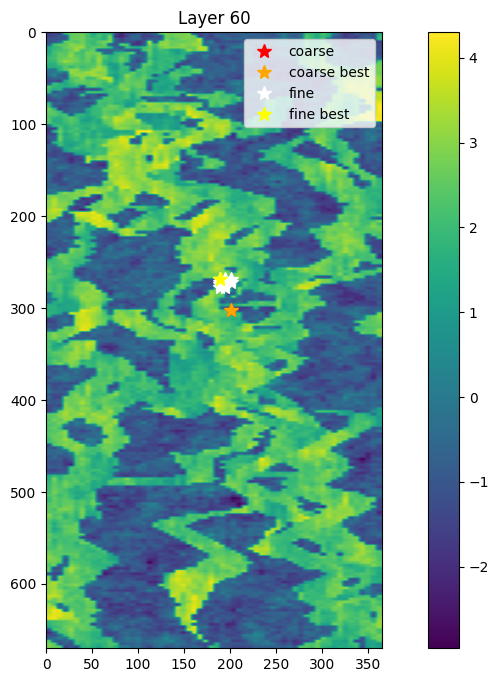

In [36]:
#Read the SPE10 grid
spe10 = Spe10(selected_layers)

# Read the permeability associated to the given layer
perm_folder = spe10_folder + "/perm/"
spe10.read_perm(perm_folder)
perm_dict = spe10.perm_as_dict()
perm = perm_dict["kxx"]
perm_2d = np.log10(perm).reshape((220, 60))

plt.figure(figsize = (12, 8))
plt.imshow(perm_2d, extent = [0, 365, 670, 0])
plt.plot(top_xy[0], top_xy[1], marker = '*', markersize = 10, linestyle = '', color = 'red', label = 'coarse')
plt.plot(top_xy[0][0], top_xy[1][0], marker = '*', markersize = 10, linestyle = '', color = 'orange', label = 'coarse best')
plt.plot(top_xy_fine[0], top_xy_fine[1], marker = '*', markersize = 10, linestyle = '', color = 'white', label = 'fine')
plt.plot(top_xy_fine[0][0], top_xy_fine[1][0], marker = '*', markersize = 10, linestyle = '', color = 'yellow', label = 'fine best')
plt.title(f'Layer {selected_layers}')
plt.colorbar()
plt.legend()